<a href="https://colab.research.google.com/github/hideousmaiden/MA_progamming_project_DS_2025/blob/main/DS_knitting_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Идея проекта заключается в том, чтобы посмотреть, каким образом будет кластеризоваться набор довольно случайных pdf-туториалов по вязанию.

- **Задача**: кластеризовать пдфки

а) по их текстовому содержанию;

б) по картинкам, которые в них вставлены.

- **Данные**: pdf-файлы, написанные по-английски. Файлы распределены по папкам в соответствии с тем, какой тип одежды там описан (свитера, носки, шарфы+шапки+перчатки+иное, изделия крючком)

Данных не очень много (127 файлов в общей сложности), так что кластеризацию я буду проводить вслепую, без обучения. После кластеризации я хочу посмотреть, что больше повлияло на кластеры -- вид изделия, дизайнер или какие-то особенности конкретных пдфок.



#Подготовка

In [1]:
try:
    from pypdf import PdfReader
except:
    !pip install pypdf
    from pypdf import PdfReader
    !pip install nltk
    !pip install -U tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.6/329.6 kB 6.0 MB/s eta 0:00:00


In [2]:
import logging

logger = logging.getLogger("pypdf")
logger.setLevel(logging.ERROR)

In [112]:
import os
import random
import pandas as pd
from google.colab import files
import csv
import numpy as np

# для текстов
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from string import punctuation
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time

#для картинок
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
#путь к папке с вязанием
os.chdir('/content/drive/MyDrive/дашины книги по вязанию/вязание')

# 1. Классификация по текстовому наполнению
#### 1.1. Парсинг текстов из pdf файлов

In [7]:
# функция открывает пдфку и достаёт оттуда текст
# лемматизирует и убирает знаки препинания

stops = stopwords.words('english')

def text_reader(address):
  reader = PdfReader(address)
  out = list()
  for page in reader.pages:
      out.append(page.extract_text())
  raw_text = ' '.join(out)
  clean_text = word_tokenize(raw_text.lower())
  clean_text = list(filter(lambda x: (x not in punctuation) & (x not in ['\n', '–', '«', '»'])
                & (x not in stops), clean_text))
  wnl = WordNetLemmatizer()
  lemm_text = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(clean_text)]
  return ' '.join(lemm_text)

In [8]:
# пдфки делятся условно на такие темы
knit_dirs = next(os.walk('.'))[1]
knit_dirs

['свитера', 'крючок', 'журналы', 'книги', 'носки', 'шарфы и прочее']

In [9]:
# для экономии времени загрузки я вручную исключу папки с книгами и журналами, т.к. они очень тяжёлые
# на общую идею повлиять не должно
knit_dirs.remove('книги')
knit_dirs.remove('журналы')

if 'картинки' in knit_dirs:
    knit_dirs.remove('картинки')
knit_dirs

['свитера', 'крючок', 'носки', 'шарфы и прочее']

In [12]:
knits = pd.DataFrame(columns=['label', 'category', 'text'])
for dir in tqdm(knit_dirs):
    for file in tqdm(os.listdir(dir), leave=False):
        tekst = text_reader(os.path.join(dir, file))
        knits = pd.concat([pd.DataFrame([[file, dir, tekst]], columns=knits.columns), knits], ignore_index=True)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [13]:
knits.head()

,name,category,text
0,davies_мёбиус.pdf,шарфы и прочее,funchal moebius street funchal pave stunning m...
1,Tortoise_and_Hare_Gauntlets_by_Kate_Davies.pdf,шарфы и прочее,long fingerless glove vikkel braid gauntlet ch...
2,kdef.pdf,шарфы и прочее,peerie flooers mittens “ peerie flooers ” mean...
3,Bubbles_amp_Brioche_Shawl_by_Stephen_West.pdf,шарфы и прочее,1 © 2020 stephen west right reserve pattern pe...
4,Aurora_Cabin_by_Stephen_West.pdf,шарфы и прочее,1 © 2022 stephen west right reserve pattern pe...


### 1.2. Векторизация текстов и кластеризация через k-means

NB: количество кластеров я задам вручную как 4

In [14]:
pdf_texts = knits['text']
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_documents = vectorizer.fit_transform(pdf_texts)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(vectorized_documents.toarray())

In [15]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=5, max_iter=500, random_state=42)
kmeans.fit(vectorized_documents)

KMeans(max_iter=500, n_clusters=4, n_init=5, random_state=42)

In [20]:
reduced_data.shape
knits.shape

(127, 3)

In [23]:
knits['text_cluster'] = kmeans.labels_

knits = pd.concat((knits, pd.DataFrame(reduced_data)), axis=1)

In [29]:
knits.columns

Index(['name', 'category', 'text', 'text_cluster', 0, 1], dtype='object')

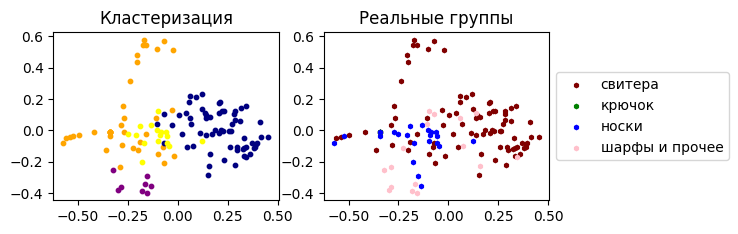

In [34]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
colors = ['orange', 'navy', 'yellow', 'purple']
cluster_labels = knit_dirs
for i in range(num_clusters):
    plt.scatter(knits.loc[knits['text_cluster'] == i, 0],
                knits.loc[knits['text_cluster'] == i, 1],
                s=10, color=colors[i],
                label=f'{cluster_labels[i]}')


colors = ['maroon', 'green', 'blue', 'pink']
ax2 = fig.add_subplot(222)
real_cats = knits['category']
for i, label in enumerate(knit_dirs):
    plt.scatter(knits.loc[knits['category'] == label, 0],
                knits.loc[knits['category'] == label, 1],
                s=10, color=colors[i],
                label=f'{cluster_labels[i]}', marker='h', alpha = 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax1.set_title('Кластеризация')
ax2.set_title('Реальные группы')

plt.show()

### 1.3. Что скластеризовалось?

In [38]:
# на графике с реальными категориями вообще не видно крючка
# это ожидаемо, т.к. крючковые схемы не содержат текста а просто узор, см. отсутствие текста ниже

knits[knits['category']=='крючок']

,name,category,text,text_cluster,0,1
38,Jintang_Reversible_Coat.pdf,крючок,,0,-0.341464,-0.012479
39,Camellia_Butterfly_Pillow_Blanket.pdf,крючок,,0,-0.341464,-0.012479
40,Ravenna_Patchwork_Blanket.pdf,крючок,,0,-0.341464,-0.012479


In [178]:
# посмотрим, какие характеристики скластеризовал kmeans
knits.loc[knits['text_cluster']==1, 'label'].values[:30]

# одна из категорий в основном собрана из дизайнеров PetiteKnit, Ozetta и MyFavouriteThings

array(['davies_мёбиус.pdf', 'kdef.pdf', 'Terrazzo_Neck_-_PetiteKnit.pdf',
       'Hipster_Hat_-_PetiteKnit.pdf', 'Hazel_Neck_-_PetiteKnit.pdf',
       'Penny_Gloves_-_PetiteKnit.pdf', 'December_Bow_-_PetiteKnit.pdf',
       'LeKnit_-_Woodlark_Sweater.pdf', 'Lac_Sweater.pdf',
       'Dagmar_Zipper_Sweater_Man_ENGLISH.pdf',
       'Lace_Loop_Sweater_-_English.pdf', 'kdb.pdf',
       'tortoise-pullover-pattern.pdf', 'october_day_xl_eng.pdf',
       'roosty_A4_2024.pdf', 'Berta_Sw_English_publish.pdf',
       'LACEY_LOOP_TEE_English.pdf', 'DROP_LOOP_TOP_English.pdf',
       'свитерок_ж.pdf', 'TV_Imprint_ENG4.pdf', 'RE_Gry_ENG2.pdf',
       'RE_Elbe_ENG2_1.pdf', 'SB_Helene_ENG4.pdf', 'JT_Helle_ENG1.pdf',
       'SBJ_Jan_ENG2.pdf', '02_HR_Koglen_ENG2.pdf',
       'MBJ_Vandglimt_ENG2.pdf', 'Hold_the_Line_-_FINAL1.pdf',
       'JUNO_Top_by_Vert.pdf', 'Sari_Nordlund_-_Lumme_Pullover.pdf'],
      dtype=object)

In [179]:
# ещё одна категория угадала носки
knits.loc[knits['text_cluster']==2]

,label,category,text,text_cluster,0,1,pics,img_cluster,0,1,img_0,img_1,img_0,img_1,img_0,img_1
1,Tortoise_and_Hare_Gauntlets_by_Kate_Davies.pdf,шарфы и прочее,long fingerless glove vikkel braid gauntlet ch...,2,-0.098208,0.123697,Tortoise_and_Hare_Gauntlets_by_Kate_Davies-Im2...,3,-200.022644,-152.461029,-200.045807,-152.494171,-200.079117,-152.827042,-415.450562,-341.790802
16,Harlequin_Socks.pdf,носки,harlequin sock 2 note construction sock knit t...,2,-0.056073,-0.034363,Harlequin_Socks-Im0.jpg,0,-84.900681,33.086479,-84.700340,34.493813,-84.857124,34.847736,-157.603806,-98.823425
18,DUSTLAND_Socks_BY_STEPHEN_WEST.pdf,носки,1 © 2022 stephen west right reserve pattern pe...,2,-0.178361,-0.199695,DUSTLAND_Socks_BY_STEPHEN_WEST-X2.jpg,3,-85.814331,183.151901,-85.918823,183.899261,-85.883354,185.714218,-128.483459,-172.543533
21,circuit_socks_v1.0.pdf,носки,circuit socksdesigned cow mar note sock featur...,2,-0.090026,-0.029218,circuit_socks_v1.0-X6.png,3,-172.024460,358.067719,-172.000504,358.272949,-172.064575,358.059937,1026.265747,1033.210327
22,Kanteletar_new_ver2.pdf,носки,kanteletar sock page 1/9 kanteletar design tii...,2,-0.103839,0.001612,Kanteletar_new_ver2-Image22.jpg,3,-65.796127,630.199585,-66.014984,629.258728,-65.860275,628.555847,145.482178,62.189888
23,Happy_Squares.pdf,носки,brighten even dullest day joyful colourful soc...,2,-0.170889,-0.082803,Happy_Squares-Image12.jpg,3,-252.649002,489.588806,-252.761078,489.553711,-252.717102,490.071808,923.119812,1784.110229
24,Solar_Flares.pdf,носки,1 solar flare design photo anna mäkilä fb kats...,2,-0.056629,-0.078562,Solar_Flares-Im0.jpg,3,-64.986923,249.092575,-64.774048,249.975067,-65.002747,250.117706,45.527596,157.894623
25,KickOffSocks_COMPACT_1.2_en.pdf,носки,kick-off sock cat krause compact edition versi...,2,-0.060038,-0.013122,KickOffSocks_COMPACT_1.2_en-Im0.jpg,3,-34.632893,186.708939,-34.594715,186.715805,-34.540428,186.937531,-185.422562,-133.128876
26,PoliceBoxSox_032615.pdf,носки,police box sox audry nicklin top sock feature ...,2,-0.098473,-0.065719,PoliceBoxSox_032615-Im0.jpg,3,-247.200516,322.335510,-247.415848,321.099152,-247.486969,320.901520,-189.379501,124.583313
27,winterwoods1.2.pdf,носки,winter wood byfishheadcreations winter wood by...,2,-0.250653,-0.022023,winterwoods1.2-Im0.jpg,3,-218.059448,261.567200,-218.307587,259.348572,-217.978439,260.296448,-161.268600,106.535454


In [180]:
# а другая исключительно состоит из работ одного дизайнера -- Stephen West
# при этом пара его работ проскочила в категорию 0
knits.loc[knits['text_cluster']==3]

,label,category,text,text_cluster,0,1,pics,img_cluster,0,1,img_0,img_1,img_0,img_1,img_0,img_1
3,Bubbles_amp_Brioche_Shawl_by_Stephen_West.pdf,шарфы и прочее,1 © 2020 stephen west right reserve pattern pe...,3,-0.166794,-0.341759,Bubbles_amp_Brioche_Shawl_by_Stephen_West-Im0.jpg,3,1017.554077,66.743538,1017.026855,66.079254,1017.320312,66.145561,5614.009277,-3576.941406
4,Aurora_Cabin_by_Stephen_West.pdf,шарфы и прочее,1 © 2022 stephen west right reserve pattern pe...,3,-0.286874,-0.361349,Aurora_Cabin_by_Stephen_West-Im0.jpg,3,711.990051,575.311218,711.760681,576.375854,712.140747,575.590637,1940.282227,-1138.646362
5,lava_lake_Stephen_West_Westknits.pdf,шарфы и прочее,1 © 2020 stephen west right reserve pattern pe...,3,-0.181143,-0.388131,lava_lake_Stephen_West_Westknits-Im0.jpg,3,-49.974281,249.285080,-49.873798,249.856918,-49.951916,249.892548,-108.541878,-104.872169
6,Glowhair_Frost_Shawl_by_Stephen_West.pdf,шарфы и прочее,1 © 2024 stephen west right reserve pattern pe...,3,-0.299647,-0.377031,Glowhair_Frost_Shawl_by_Stephen_West-Im0.jpg,3,870.583984,156.081055,870.555237,156.625320,870.888123,155.916733,713.303284,-581.004028
7,Mesmerizing_Mermaid_Shawl_by_Stephen_West_-_We...,шарфы и прочее,1 © 2024 stephen west right reserve pattern pe...,3,-0.155117,-0.395726,Mesmerizing_Mermaid_Shawl_by_Stephen_West_-_We...,3,989.946167,265.664276,990.732422,263.482422,989.790222,264.926300,433.162842,-270.900909
8,Mosaic_Musings_by_Stephen_West.pdf,шарфы и прочее,1 © 2019 stephen west right reserve pattern pe...,3,-0.325019,-0.250770,Mosaic_Musings_by_Stephen_West-Im0.jpg,3,442.779602,145.512924,442.735107,145.556000,442.877716,144.966782,580.743774,-228.425018
17,Spring_Cleaning_Socks_1.pdf,носки,1 © 2025 stephen west right reserve pattern pe...,3,-0.134910,-0.351456,Spring_Cleaning_Socks_1-Im0.jpg,3,-40.814941,616.012268,-41.010654,615.996277,-40.679985,616.578979,467.476074,217.519196
19,Color_Popportunity_Socks_v1_by_Stephen_West_EN...,носки,1 © 2024 stephen west right reserve pattern pe...,3,-0.152735,-0.290342,Color_Popportunity_Socks_v1_by_Stephen_West_EN...,3,151.560928,474.535431,151.582642,475.558716,151.529709,475.625977,306.685486,202.044037


# 2. Классифицируем по картинкам

### 2.1. Вытаскиваем картинки

(600, 600)
(1638, 2048)


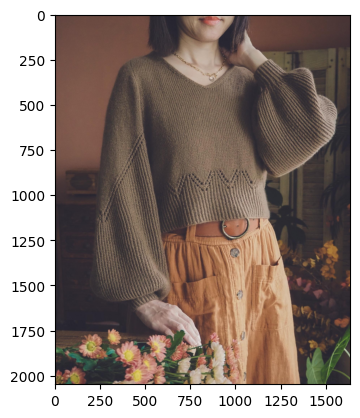

In [161]:
reader = PdfReader("./свитера/Afra-sweater.pdf")

def pic_shower(f_name):
    img = cv2.imread(f_name)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image)


page = reader.pages[0]

for i, image_file_object in enumerate(page.images):
    file_name = "out-image-" + str(i) + "-" + image_file_object.name
    image_file_object.image.save(file_name)
    #print(image_file_object.image.size)
    pic_shower(file_name)

In [98]:
os.mkdir('картинки')

In [99]:
#функция для вытаскивания картинок
# в рамках лени будем смотреть на картинки только с первой страницы


# чтобы не вытаскивать декоративные элементы, буду выбирать самую большую картинку на странице
# это с большей вероятностью будет изображение самого изделия
def get_img_size(path):
    width, height = path.image.size
    return width*height

def image_grabber(file_path):
    reader = PdfReader(file_path)
    page = reader.pages[0]
    largest = max(page.images, key=get_img_size)
    label = os.path.splitext(os.path.split(file_path)[1])[0]
    file_name = label + "-" + largest.name
    largest.image.save(os.path.join('картинки', file_name))
    return file_name

In [100]:
knits['pics'] = knits.apply(lambda x: image_grabber(os.path.join(x.category, x.label)), axis=1)

In [104]:
knits.head()

,label,category,text,text_cluster,0,1,pics
0,davies_мёбиус.pdf,шарфы и прочее,funchal moebius street funchal pave stunning m...,1,-0.106201,0.042335,davies_мёбиус-Im1.png
1,Tortoise_and_Hare_Gauntlets_by_Kate_Davies.pdf,шарфы и прочее,long fingerless glove vikkel braid gauntlet ch...,2,-0.098208,0.123697,Tortoise_and_Hare_Gauntlets_by_Kate_Davies-Im2...
2,kdef.pdf,шарфы и прочее,peerie flooers mittens “ peerie flooers ” mean...,1,-0.071075,0.106085,kdef-Im4.jpg
3,Bubbles_amp_Brioche_Shawl_by_Stephen_West.pdf,шарфы и прочее,1 © 2020 stephen west right reserve pattern pe...,3,-0.166794,-0.341759,Bubbles_amp_Brioche_Shawl_by_Stephen_West-Im0.jpg
4,Aurora_Cabin_by_Stephen_West.pdf,шарфы и прочее,1 © 2022 stephen west right reserve pattern pe...,3,-0.286874,-0.361349,Aurora_Cabin_by_Stephen_West-Im0.jpg


### 2.2. Векторизация и кластеризация картинок

In [156]:
#image.LOAD_TRUNCATED_IMAGES = True
model = VGG16(weights='imagenet', include_top=False)

num_clusters = 4

# Loop over files and get features
filelist = knits.apply(lambda x: os.path.join('картинки', x.pics), axis=1).values
#filelist.sort()
featurelist = []
for i, imagepath in enumerate(filelist):
    print("    Status: %s / %s" %(i, len(filelist)), end="\r")
    img = image.load_img(imagepath, target_size=(1024,1024))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())

# Clustering
kmeans_img = KMeans(n_clusters=num_clusters, random_state=42).fit(np.array(featurelist))

knits['img_cluster'] = kmeans_img.labels_

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━

In [157]:
# делаем векторы двумерными для графика
pca = PCA(n_components=2)
img_reduced_data = pca.fit_transform(np.array(featurelist))
knits = pd.concat((knits, pd.DataFrame(img_reduced_data, columns= ['img_0', 'img_1'])), axis=1)

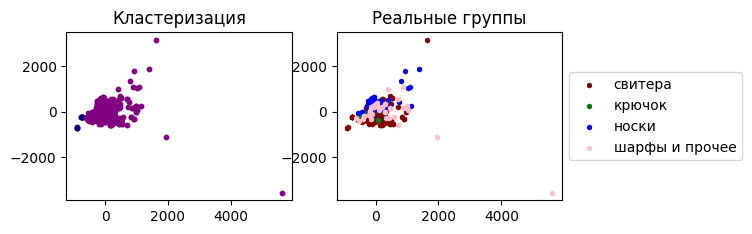

In [158]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
colors = ['orange', 'navy', 'yellow', 'purple']
cluster_labels = knit_dirs
for i in range(num_clusters):
    plt.scatter(knits.loc[knits['img_cluster'] == i, 'img_0'],
                knits.loc[knits['img_cluster'] == i, 'img_1'],
                s=10, color=colors[i],
                label=f'{cluster_labels[i]}')


colors = ['maroon', 'green', 'blue', 'pink']
ax2 = fig.add_subplot(222)
real_cats = knits['category']
for i, label in enumerate(knit_dirs):
    plt.scatter(knits.loc[knits['category'] == label, 'img_0'],
                knits.loc[knits['category'] == label, 'img_1'],
                s=10, color=colors[i],
                label=f'{cluster_labels[i]}', marker='h', alpha = 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


ax1.set_title('Кластеризация')
ax2.set_title('Реальные группы')

plt.show()

### 2.3. Что скластеризовалось?

In [162]:

knits[knits['img_cluster'] == 0]

,label,category,text,text_cluster,0,1,pics,img_cluster,0,1,img_0,img_1,img_0,img_1,img_0,img_1
16,Harlequin_Socks.pdf,носки,harlequin sock 2 note construction sock knit t...,2,-0.056073,-0.034363,Harlequin_Socks-Im0.jpg,0,-84.900681,33.086479,-84.700340,34.493813,-84.857124,34.847736,-157.603806,-98.823425
28,Popinjay_Socks_EN_v2.pdf,носки,popinjay sock karolina adamczyk share instagra...,2,-0.132167,0.033617,Popinjay_Socks_EN_v2-Im1.png,0,-92.990669,554.770264,-92.897537,554.670776,-93.095978,555.101624,78.179947,160.300858
47,tortoise-pullover-pattern.pdf,свитера,© kate davy http //needled.wordpress.com torto...,1,0.090586,0.210845,tortoise-pullover-pattern-Im1.jpg,0,-252.476517,-261.782257,-252.501282,-261.829803,-252.553314,-262.017761,-566.165771,-357.719543
56,свитерок_ж.pdf,свитера,version 1 andromeda woman ’ pullover star comm...,1,-0.027052,0.036098,свитерок_ж-Im1.jpg,0,-334.391144,-108.930923,-334.510773,-108.939339,-334.369171,-108.686287,-375.531921,-133.853561
61,JT_Helle_ENG1.pdf,свитера,obsess quality yarn since 1952 filcolanahelle ...,1,0.298146,-0.126865,JT_Helle_ENG1-Im0.jpg,0,-146.121582,-188.624390,-146.159714,-188.209106,-146.141541,-188.383438,-424.426636,-178.637817


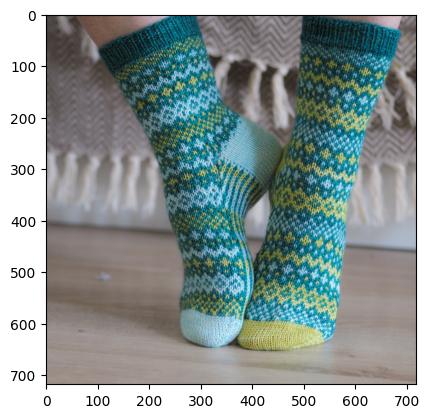

In [189]:
# первая группа получилась рандомная
pic = knits.loc[knits['img_cluster'] == 0, 'pics'].values[1]
img = os.path.join('картинки', pic)
pic_shower(img)

In [190]:
knits[knits['img_cluster'] == 2]

,label,category,text,text_cluster,0,1,pics,img_cluster,0,1,img_0,img_1,img_0,img_1,img_0,img_1
15,December_Bow_-_PetiteKnit.pdf,шарфы и прочее,december bow _________________________________...,1,0.074195,-0.096214,December_Bow_-_PetiteKnit-Im0.jpg,2,-180.034744,47.418747,-179.530853,49.052975,-179.901382,48.225864,49.108341,247.148636


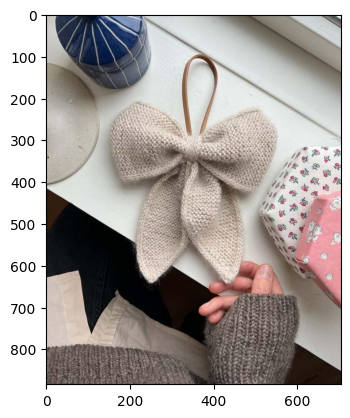

In [191]:
# во вторую группу выделилось одно очень серое изображение
pic = knits.loc[knits['img_cluster'] == 2, 'pics'].values[0]
img = os.path.join('картинки', pic)
pic_shower(img)

In [192]:
knits[knits['img_cluster'] == 3]

,label,category,text,text_cluster,0,1,pics,img_cluster,0,1,img_0,img_1,img_0,img_1,img_0,img_1
0,davies_мёбиус.pdf,шарфы и прочее,funchal moebius street funchal pave stunning m...,1,-0.106201,0.042335,davies_мёбиус-Im1.png,3,-360.779114,-175.409317,-360.747864,-175.345856,-360.788910,-175.472153,-620.354858,-292.489899
1,Tortoise_and_Hare_Gauntlets_by_Kate_Davies.pdf,шарфы и прочее,long fingerless glove vikkel braid gauntlet ch...,2,-0.098208,0.123697,Tortoise_and_Hare_Gauntlets_by_Kate_Davies-Im2...,3,-200.022644,-152.461029,-200.045807,-152.494171,-200.079117,-152.827042,-415.450562,-341.790802
2,kdef.pdf,шарфы и прочее,peerie flooers mittens “ peerie flooers ” mean...,1,-0.071075,0.106085,kdef-Im4.jpg,3,-145.730865,-342.753418,-145.710617,-342.946106,-145.808212,-343.002716,-522.713806,-414.270966
3,Bubbles_amp_Brioche_Shawl_by_Stephen_West.pdf,шарфы и прочее,1 © 2020 stephen west right reserve pattern pe...,3,-0.166794,-0.341759,Bubbles_amp_Brioche_Shawl_by_Stephen_West-Im0.jpg,3,1017.554077,66.743538,1017.026855,66.079254,1017.320312,66.145561,5614.009277,-3576.941406
4,Aurora_Cabin_by_Stephen_West.pdf,шарфы и прочее,1 © 2022 stephen west right reserve pattern pe...,3,-0.286874,-0.361349,Aurora_Cabin_by_Stephen_West-Im0.jpg,3,711.990051,575.311218,711.760681,576.375854,712.140747,575.590637,1940.282227,-1138.646362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Sweater_No_20_-_My_Favourite_Things.pdf,свитера,1 sweater 20 sweaterno20 sweater 20 sweater 20...,1,0.344076,-0.107664,Sweater_No_20_-_My_Favourite_Things-X0.jpg,3,-241.046997,96.703468,-240.991608,96.661697,-241.001801,96.354050,482.312531,342.852631
123,футболка.pdf,свитера,,0,-0.341464,-0.012479,футболка-Im0.jpg,3,-405.032196,-151.675705,-405.014038,-151.637543,-405.025116,-151.596039,-573.227478,-247.464050
124,полосатый_пуловер.pdf,свитера,purl-willing 1 7 ©lone kjeldsen размер для фак...,0,-0.496653,-0.026316,полосатый_пуловер-Im1.jpg,3,237.079453,323.136169,236.742416,323.371826,236.974747,322.948914,113.173462,333.650146
125,кофточка_с_косами.pdf,свитера,beatrixcardigan кардиганbeatrixизлучаетнеприну...,0,-0.419907,-0.011315,кофточка_с_косами-X9.png,3,-111.209068,94.128204,-111.136940,93.904327,-111.221573,93.674416,-166.293457,-2.787634


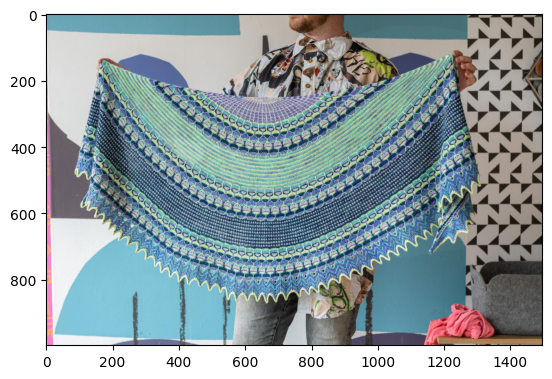

In [175]:
# в третью группу попало всё подряд
pic = knits.loc[knits['img_cluster'] == 3, 'pics'].values[4]
img = os.path.join('картинки', pic)
pic_shower(img)

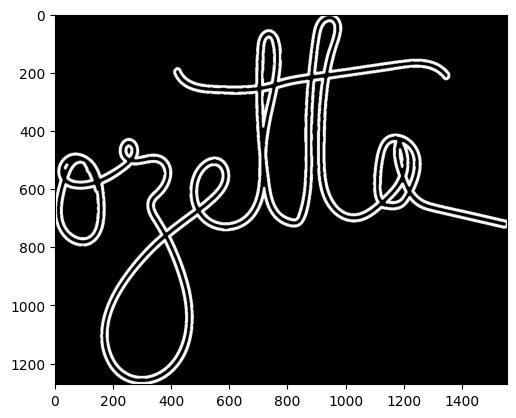

In [174]:
#а в четвёртую попали случайно просочившиеся лейблы или элементы дизайна как ниже
pic = knits.loc[knits['img_cluster'] == 1, 'pics'].values[0]
img = os.path.join('картинки', pic)
pic_shower(img)

In [176]:
knits.shape

(127, 16)